### Load and inspect the data

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
LABEL_COL = "target"
ID_COLS = ['Src IP', 'Dst IP', 'Timestamp']

df_train = pd.read_csv("data/train.csv")
df_val = pd.read_csv("data/validation.csv")
df_test = pd.read_csv("data/test.csv")

# todo: remove dstport removal

X_train = df_train.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp", "DstPortRange_well_known"])
y_train = df_train[LABEL_COL]
X_val = df_val.drop(columns=['target', 'Src IP', 'Dst IP', 'Timestamp', "DstPortRange_well_known"])
y_val = df_val[LABEL_COL]
X_test  = df_test.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp", "DstPortRange_well_known"])
y_test  = df_test[LABEL_COL]

print(df_train.shape)
print(df_train.columns)
print(df_train.loc[1])


(25901651, 17)
Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')
Timestamp                  2018-02-16 12:38:45.787171
Src IP                                   172.31.66.26
Dst IP                                  23.219.88.169
Bwd Packet Length Min                               0
Protocol_6                                       True
Bwd Packets/s                                0.133515
FWD Init Win Bytes                               8192
Packet Length Std                          113.214348
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                   0
Fwd Seg Size Min  

### Examine the data

In [2]:
# EXTRA STEP TO ENSURE SAME COLUMN ORDER BETWEEN TRAIN AND TEST SETS
X_test = X_test[X_train.columns]
assert list(X_train.columns) == list(X_test.columns)

In [3]:
print("Training distribution:")
print(y_train.value_counts())
print(f"Training malicious ratio: {y_train.value_counts()[1] / len(y_train):.6f}")

print("\nTest distribution:")
print(y_test.value_counts())
print(f"Test malicious ratio: {y_test.value_counts()[1] / len(y_test):.6f}")

Training distribution:
target
0    23414921
1     2486730
Name: count, dtype: int64
Training malicious ratio: 0.096007

Test distribution:
target
0    12679742
1      183030
Name: count, dtype: int64
Test malicious ratio: 0.014229


### Train the XGBoost model with best hyper-params

In [4]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (25901651, 12)
y_train shape: (25901651,)
X_val shape: (6475413, 12)
y_val shape: (6475413,)


In [ ]:
### ALTERNATIVE with validation
import xgboost as xgb
from xgboost.callback import EarlyStopping

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

scale = y_train.value_counts()[0] / y_train.value_counts()[1]

params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    scale_pos_weight=scale,
)

# params = dict(
#     learning_rate=0.1,
#     n_estimators=1_000,
#     max_depth=5,
#     min_child_weight=1,
#     gamma=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_alpha=0,
#     scale_pos_weight=scale,
#     # max_delta_step=1,
#     eval_metric="auc",
#     tree_method="hist",
#     random_state=42,
# )

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dval, "val")],
    callbacks=[EarlyStopping(rounds=50, save_best=True)]
)

print("Best iteration:", model.best_iteration)
print("Best AUC:", model.best_score)

[0]	train-auc:0.99997	val-auc:0.69692
[1]	train-auc:0.99999	val-auc:0.88212
[2]	train-auc:0.99999	val-auc:0.87949
[3]	train-auc:0.99999	val-auc:0.87022
[4]	train-auc:0.99999	val-auc:0.99274
[5]	train-auc:0.99999	val-auc:0.99073
[6]	train-auc:1.00000	val-auc:0.98941
[7]	train-auc:0.99999	val-auc:0.98797
[8]	train-auc:1.00000	val-auc:0.98623
[9]	train-auc:1.00000	val-auc:0.98610
[10]	train-auc:1.00000	val-auc:0.98594
[11]	train-auc:1.00000	val-auc:0.98594
[12]	train-auc:1.00000	val-auc:0.98517
[13]	train-auc:0.99999	val-auc:0.97110
[14]	train-auc:0.99999	val-auc:0.97098
[15]	train-auc:1.00000	val-auc:0.97091
[16]	train-auc:0.99999	val-auc:0.98002
[17]	train-auc:0.99999	val-auc:0.98001
[18]	train-auc:0.99999	val-auc:0.98001
[19]	train-auc:0.99999	val-auc:0.97963
[20]	train-auc:1.00000	val-auc:0.97785


KeyboardInterrupt: 

Best threshold: 0.0091
Best F1: 0.1006
ROC-AUC: 0.3117
PR-AUC: 0.0216
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99  12679742
   Malicious       0.10      0.10      0.10    183030

    accuracy                           0.97  12862772
   macro avg       0.54      0.55      0.54  12862772
weighted avg       0.97      0.97      0.97  12862772

[[12502156   177586]
 [  163928    19102]]


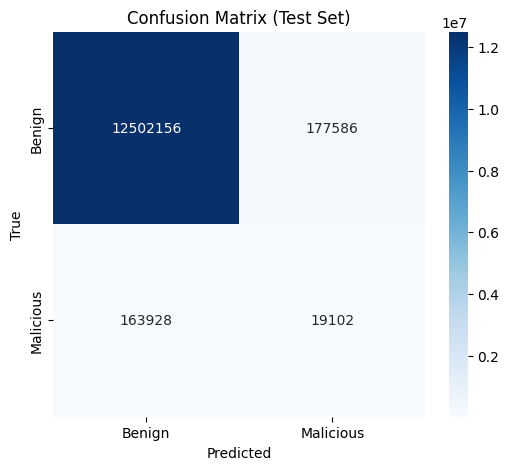

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# --- Create DMatrix for test data ---
dtest = xgb.DMatrix(X_test, label=y_test)

# --- Get predicted probabilities ---
y_proba = model.predict(dtest)   # already probabilities in [0, 1]

# --- Compute PR curve and best threshold (by F1) ---
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-8)

best_thr = thr[np.argmax(f1)]
print(f"Best threshold: {best_thr:.4f}")
print(f"Best F1: {f1.max():.4f}")

# TESTING MANUAL THRESHOLD
# best_thr = 0.25

# --- Apply threshold ---
y_pred = (y_proba >= best_thr).astype(int)

# --- Evaluate metrics ---
roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Plot the ROC curve

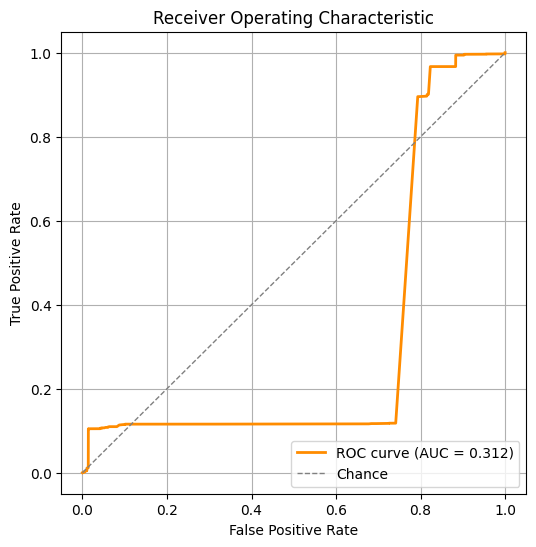

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Precision–Recall curve

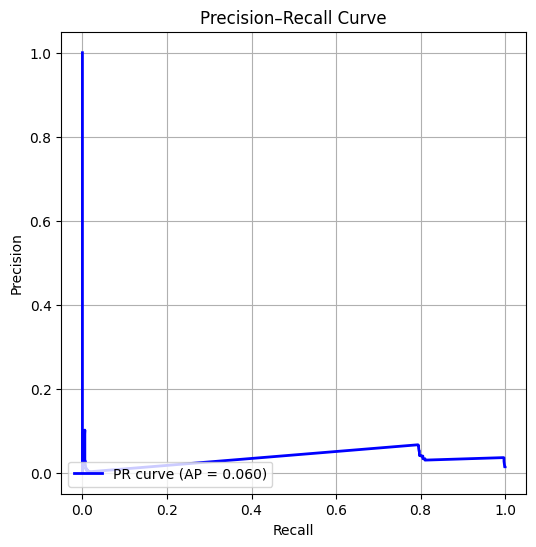

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color='blue', lw=2, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Plot distribution of predicted probabilities for both classes

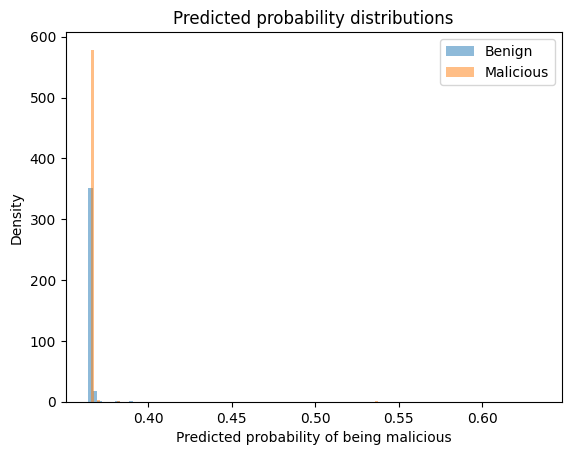

In [15]:
import matplotlib.pyplot as plt

# y_proba = model.predict_proba(X_test)[:,1]
plt.hist(y_proba[y_test==0], bins=100, alpha=0.5, label="Benign", density=True)
plt.hist(y_proba[y_test==1], bins=100, alpha=0.5, label="Malicious", density=True)
plt.legend()
plt.xlabel("Predicted probability of being malicious")
plt.ylabel("Density")
plt.title("Predicted probability distributions")
plt.show()

### Step 7. (Optional) Time-aware cross-validation

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# import numpy as np

# complete_df = pd.concat([df_train, df_test])
# tscv = TimeSeriesSplit(n_splits=5)
# for fold, (train_idx, test_idx) in enumerate(tscv.split(complete_df)):
#     Xtr, Xte = complete_df.iloc[train_idx][EDGE_COLS], complete_df.iloc[test_idx][EDGE_COLS]
#     ytr, yte = complete_df.iloc[train_idx][LABEL_COL], complete_df.iloc[test_idx][LABEL_COL]
#     model.fit(Xtr, ytr)
#     preds = model.predict_proba(Xte)[:,1]
#     auc = roc_auc_score(yte, preds)
#     print(f"Fold {fold+1}: AUC={auc:.4f}")

In [ ]:
model.save_model("models/xgboost.json")

In [13]:
# # To reload later
# from xgboost import XGBClassifier
# model = XGBClassifier()
# model.load_model("models/xgboost.json")

#### Print results table in Latex format

In [14]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, digits=4, output_dict=True)

import pandas as pd

report_df = pd.DataFrame(report_dict).transpose()
latex_table = report_df.to_latex(float_format="%.4f")

print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 1.0000 & 0.9978 & 0.9989 & 5391219.0000 \\
1 & 0.9891 & 0.9998 & 0.9944 & 1084194.0000 \\
accuracy & 0.9981 & 0.9981 & 0.9981 & 0.9981 \\
macro avg & 0.9945 & 0.9988 & 0.9967 & 6475413.0000 \\
weighted avg & 0.9981 & 0.9981 & 0.9981 & 6475413.0000 \\
\bottomrule
\end{tabular}

